In [2]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Extrai arrays para a regressão linear
def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    # Exclui linhas que tenham nulos
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    # Ordena dataframe
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]# / pd.to_timedelta(1, unit='D')
    y = ordered_notna[y_name] #/ pd.to_timedelta(1, unit='D')
    # Preserva nome ddas colunas caso necessário
    if return_label:
        # Converte para float64 caso e x e y estejam em formato de data
        extract_xy.labels = ordered_notna[return_label]
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy


# Calcula coeficientes da regressão linear
def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


In [5]:
# Dicionários com fase e marco que marca seu início
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

In [6]:
# Carrega tabelas
df = pd.read_excel("./Outputs/previsor_resultados.xlsx",sheet_name='Teste regressao')
tabela_previsor = pd.read_parquet("./Outputs/tabela_previsor.gzip")

In [7]:
lista_geracao = df.SigTipoGeracao.unique()

In [8]:
num_subplots = len(lista_geracao) * len(dict_fase_marco)

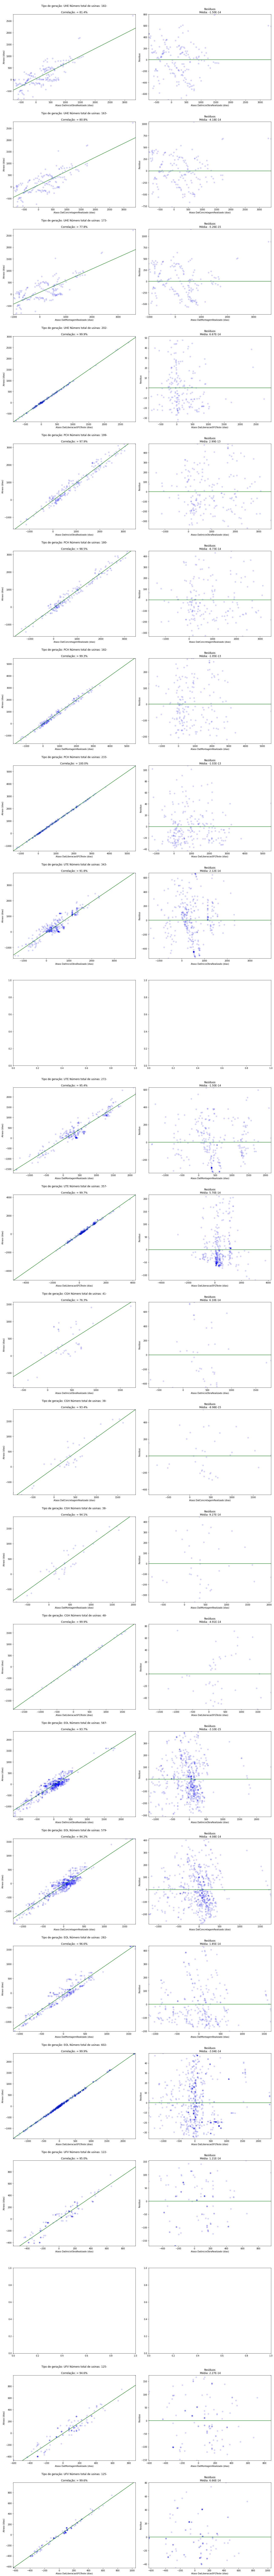

In [9]:
z_score_max = 1.65 # Escore-z que representa percentil de aproximadamente 90%. Será usado para a identificação de outliers
fig, axes = plt.subplots(num_subplots,2,figsize=(18,num_subplots*7))
count = 0

dict_atrasos = {}

for SigTipoGeracao in lista_geracao:
    dict_atrasos[SigTipoGeracao] = {}
    for fase,marco in dict_fase_marco.items():
        ax = axes[count]
        count += 1
        mask_geracao = (df.SigTipoGeracao == SigTipoGeracao)
        marco_ataso = f"{marco}_atraso_ambos"
        # Média e desvio padrão do tempo de duração de fase
        m = tabela_previsor[(tabela_previsor.Comercialização=="Ambos") & (tabela_previsor.Fase == fase) & (tabela_previsor["Tipo de geração"]==SigTipoGeracao)].Media_Fase.iloc[0]/pd.Timedelta(1,"D")
        std = tabela_previsor[(tabela_previsor.Comercialização=="Ambos") & (tabela_previsor.Fase == fase) & (tabela_previsor["Tipo de geração"]==SigTipoGeracao)].Std_Fase.iloc[0]/pd.Timedelta(1,"D")
        # Tempo máximo de duração das fases para identificar outliers
        tempo_max = (z_score_max*std)+m
        tempo_min= -(z_score_max*std)+m
        outliers = ((df[fase]) > tempo_max)| ((df[fase]) < tempo_min)
        try:
            x,y = extract_xy(df[mask_geracao & (~outliers)],x_name=marco_ataso,y_name="Atraso",order_by=marco_ataso)
            dict_atrasos[SigTipoGeracao][marco] = x
            dict_atrasos[SigTipoGeracao]["Atraso"] = y
            # Coeficientes da regressão linear
            a, b, r, p_value, std_err = calc_regression(x,y)
        except  ValueError:
            continue          
        
        # Plot                     
        x_plot = np.linspace((x).min()-10,(x).max()+10,100)
        ax[0].plot(x_plot,a*x_plot+b,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
        ax[0].scatter(x,y,color="blue",alpha=0.15,label="Dados utilizados")
        ax[0].set_xlim((x).min(),(x).max())
        ax[0].set_ylim((y).min(),(y).max())
        ax[0].set_title(f"""\nTipo de geração: {SigTipoGeracao} Número total de usinas: {x.shape[0]}-\n\nCorrelação: = {f"{100*r:.1f}%"}""")
        ax[0].set_xlabel(f"Ataso {marco} (dias)")
        ax[0].set_ylabel(f"Atraso (dias)")

        ################################## Resíduos
        ax[1].axhline(y=0,xmin=x.min(),xmax=x.max(),color="green")
        y_residuo = y - (x*a+b)
        ax[1].scatter(x,y_residuo,color="blue",alpha=0.15,label="Resíduo")
        ax[1].set_xlim((x).min(),(x).max())
        ax[1].set_ylim((y_residuo).min(),(y_residuo).max())
        ax[1].set_title(f"Resíduos\n Média: {y_residuo.mean():.2E}")
        ax[1].set_xlabel(f"Ataso {marco} (dias)")
        ax[1].set_ylabel(f"Resíduo")

        plt.tight_layout()

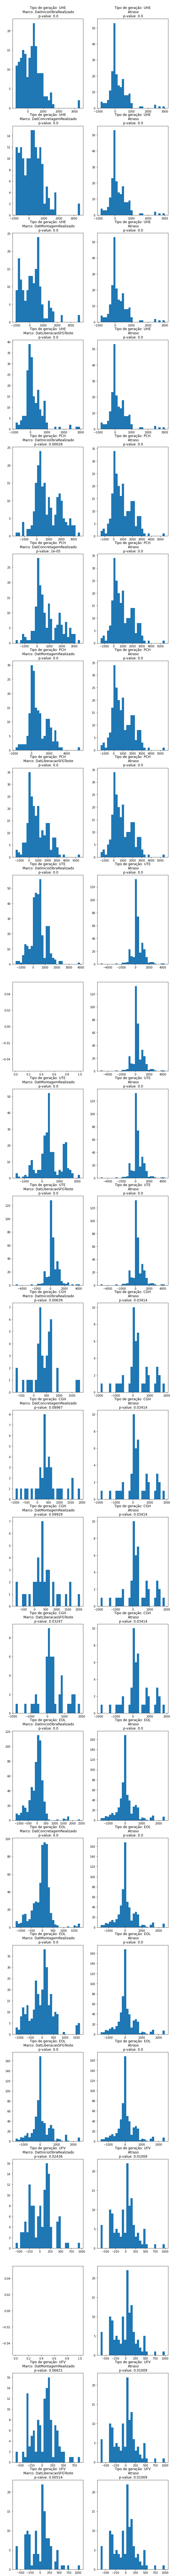

In [11]:
fig, axes = plt.subplots(num_subplots,2,figsize=(10,num_subplots*7))
count = 0
for SigTipoGeracao in lista_geracao:
    for fase,marco in dict_fase_marco.items():
        ax = axes[count]
        count +=1
        atraso_marco = dict_atrasos[SigTipoGeracao][marco]
        atraso = dict_atrasos[SigTipoGeracao]["Atraso"]
        ax[0].hist(atraso_marco,bins=30)
        ax[1].hist(atraso,bins=30)
        try:
            p_value_atraso_marco = round(stats.shapiro(atraso_marco).pvalue,5)
            p_value_atraso = round(stats.shapiro(atraso).pvalue,5)
        except:
            continue
        ax[0].set_title(f"""\nTipo de geração: {SigTipoGeracao}\n Marco: {marco}\n p-value: {p_value_atraso_marco}""")
        ax[1].set_title(f"""\nTipo de geração: {SigTipoGeracao}\n Atraso\n p-value: {p_value_atraso}""")